# EDA - HealthGuard Insurance Cross-Sell 

## Contextualization

Our client, an insurance company, is seeking our assistance in creating a predictive model to determine the likelihood of policyholders from the previous year being interested in the company's vehicle insurance. 

Insurance policies involve an agreement in which an insurance company guarantees compensation for specific losses, damages, illnesses, or death in exchange for regular premium payments. For instance, customers may pay an annual premium of $5000 to receive health insurance coverage worth $200.000. If a customer becomes ill and requires hospitalization, the insurance provider will cover the cost of hospitalization up to Rs. $200.000. This concept relies on probabilities, as only a few customers will require hospitalization each year out of a larger pool of premium-paying customers.

Similarly, vehicle insurance requires customers to pay an annual premium to an insurance provider. In case of an unfortunate accident, the insurance provider will compensate the customer with a compensation called 'sum assured'. 

Predicting a customer's interest in vehicle insurance is crucial for the company to optimize its business model and revenue.

## Business Problem
1. The product team is seeking to create a predictive tool capable of identifying, in a database of 127,000 customers, those with the highest likelihood of joining the new premium health/automobile insurance plan. This is because the plan enrollment will be done through direct contact by the sales team, via phone calls, with only 2000 calls available to contact customers.

2. It is important to note that the tool needs to have a minimum accuracy of 80% to ensure profitability for the company in the creation of the new plan.

## Solution Planning

1. **Data exploration:** Explore the data to understand its features, identify any missing values or outliers, and clean the data if necessary.
2. **Raise hypotheses:** Create and validate hypotheses in search of correlations that may be useful for the machine learning model and also help identify possible insights that may be useful to the business team.
3. **Feature engineering:** We need to create new features or transform existing features to help the model learn patterns and make better predictions.
4. **Model selection:** We need to select an appropriate machine learning model that can handle the problem and the data.
5. **Model training and evaluation:** We need to train the model on a training set and evaluate its performance on a validationset using appropriate metrics such as accuracy, precision, recall, and F1 score.
6. **Hyperparameter tuning:** We need to tune the hyperparameters of the model to optimize its performance.
7. **Model deployment:** We need to deploy the model to production and integrate it with the company's systems.

# 0.0. Imports, Functions, Settings and Data Loading

## 0.1. Imports

In [192]:
import sys
import inflection

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from PIL                   import Image
from IPython.core.display  import HTML

from scipy                 import stats  as ss
from matplotlib            import pyplot as plt

## 0.2. Functions

In [248]:
def get_percentage(value, total):         
    return round( ( value * 100 ) / total, 2 )

def cramer_v_bias_correction(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
    """
    
    confusion_matrix = pd.crosstab(x, y).values
    
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()



#============================================================
#           HELPER FUNCTIONS
#============================================================

#Rename Dataframe Columns to snanakecase
def change_columns(columns):
    """
    Rename a list of values to columns name in Dataframe to snakecase format.
    
    Examples: 
    Old Columns: 'DayOfWeek', 'Date', 'Sales'
    Return: 'day_of_week', 'date', 'sales'
        
    Old Columns: 'Day_Of_Week', 'StoreType', 'Sales'
    Return: 'day_of_week', 'store_type', 'sales'
    
    """
    cols_old = columns
    snakecase = lambda x: inflection.underscore( x )

    cols_new = list( map( snakecase, cols_old ) )
    
    return cols_new

def get_numerical_descriptive_statistic(numerical_attributes):
    # Measures of central tendency (mean and median)
    t1 = pd.DataFrame( numerical_attributes.apply( np.mean ) ).T
    t2 = pd.DataFrame( numerical_attributes.apply( np.median ) ).T

    # Dispersion measure - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( numerical_attributes.apply( np.std ) ).T
    d2 = pd.DataFrame( numerical_attributes.apply( np.min ) ).T
    d3 = pd.DataFrame( numerical_attributes.apply( np.max ) ).T
    d4 = pd.DataFrame( numerical_attributes.apply( lambda x: x.max() - x.min() ) ).T
    d5 = pd.DataFrame( numerical_attributes.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( numerical_attributes.apply( lambda x: x.kurtosis() ) ).T

    #concat
    m1 = pd.concat( [ d2, d3, d4, t1, t2, d1, d5, d6 ] ).T.reset_index()
    m1.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m1

def plot_skew_kurtosis(list, sup_title=None):
    skewness = stats.skew(list)
    kurtosis = stats.kurtosis(list)
    num_bins = int(np.ceil(np.log2(len(list))) + 1)

    # Plotting o histogram
    plt.figure( figsize=(8,4))
    plt.hist(list, bins=num_bins)

    # Adding vertical lines of skewness e kurtosis
    plt.axvline(x=stats.mode(list, keepdims=True)[0], color='r', linestyle='--', label=f"Mode={stats.mode(list, keepdims=True)[0]}")
    plt.axvline(x=np.median(list), color='g', linestyle='--', label=f"Median={np.median(list)}")
    plt.axvline(x=np.mean(list), color='b', linestyle='--', label=f"Mean={np.mean(list)}")
    plt.axvline(x=np.mean(list)+np.std(list), color='y', linestyle='--', label=f"Standard Deviation={np.std(list)}")

    
    plt.title(f"Skewness={skewness:.2f}, Kurtosis={kurtosis:.2f}")
    # Adicionando as informações de skewness e kurtosis ao título do gráfico
    if sup_title != None:
        plt.suptitle(sup_title)
        
    plt.show()

## 0.3 Settings

In [194]:
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.2f' % x)

jupyter_settings()

root_path = sys.path[0]

## 0.4. Data Loading

In [195]:
df_raw         = pd.read_csv( root_path+'/repos/dataset/healthguard_customers.csv', low_memory=False )
df_potencial   = pd.read_csv( root_path+'/repos/dataset/potencial_customers.csv', low_memory=False )

# 1.0. Data Exploration

In [196]:
df1 = df_raw.copy()
df1.columns = change_columns(df1.columns)
df_potencial.columns = change_columns(df_potencial.columns)

In [197]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.00,0,> 2 Years,Yes,40454.00,26.00,217,1
1,2,Male,76,1,3.00,0,1-2 Year,No,33536.00,26.00,183,0
2,3,Male,47,1,28.00,0,> 2 Years,Yes,38294.00,26.00,27,1
3,4,Male,21,1,11.00,1,< 1 Year,No,28619.00,152.00,203,0
4,5,Female,29,1,41.00,1,< 1 Year,No,27496.00,152.00,39,0


## 1.1. Data Description



- **Id:** Unique ID for each customer.
- **Gender:** Gender of the customer.
- **Age:** Age of the customer.
- **Driving License:** 0: Customer does not have DL, 1: Customer already has DL.
- **Region Code:** Unique code for the region of the customer.
- **Previously Insured:** 1: Customer already has Vehicle Insurance, 0: Customer doesn't.
- **Vehicle Age:** Age of the Vehicle.
- **Vehicle Damage:** 1: Customer got his/her vehicle damaged in the past, 0: Customer didn't get his/her vehicle damaged in the past.
- **Anual Premium:** The amount customer needs to pay as premium in the year.
- **Policy sales channel:** Anonymized Code for the channel of outreaching to the customer, i.e., Different Agents, Over Mail, Over Phone, In Person, etc.
- **Vintage:** Number of Days, Customer has been associated with the company.
- **Response:** 1: Customer is interested, 0: Customer is not interested.


### 1.1.1. Dimension

In [198]:
print( 'Dimentions to HealthGuard database ')
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Cols: {df1.shape[1]}' )

print( '\nDimentions to Potencial Primium HealthGuard Customers database ')
print( f'Number of Rows: {df_potencial.shape[0]}' )
print( f'Number of Cols: {df_potencial.shape[1]}' )

Dimentions to HealthGuard database 
Number of Rows: 381109
Number of Cols: 12

Dimentions to Potencial Primium HealthGuard Customers database 
Number of Rows: 127037
Number of Cols: 11


### 1.1.2. Types

The two databases have practically the same information, however the base of potential premium customers does not have the Response column, as this will be the column used in the prediction response.

In [199]:
print( 'Data Types to HealthGuard Customers database ')
df1.dtypes

Data Types to HealthGuard Customers database 


id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [200]:
print( 'Data Types to Potencial Primium HealthGuard Customers database ')
df_potencial.dtypes

Data Types to Potencial Primium HealthGuard Customers database 


id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
dtype: object

### 1.1.3. Missing Values

No missing data in databses. It will not be necessary to clean or delete missing records in both databases.

In [201]:
print( 'Missing Values to HealthGuard Customers database ')
df1.isna().sum()

Missing Values to HealthGuard Customers database 


id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

In [202]:
print( 'Missing Values to Potencial Primium HealthGuard Customers database ')
df_potencial.isna().sum()

Missing Values to Potencial Primium HealthGuard Customers database 


id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
dtype: int64

### 1.1.4. Change Types

- Changing the values 0 to No and 1 to Yes to help on data analysis.
- Change Float64 type of region_code and policy_sales_channel to int64

In [203]:
dic = {1:'Yes', 0:'No'}

df1['driving_license'] = df1['driving_license'].map(dic)
df1['previously_insured'] = df1['previously_insured'].map(dic)
df1['response'] = df1['response'].map(dic)

df1['region_code'] = df1['region_code'].astype('int64')
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,Yes,28,No,> 2 Years,Yes,40454.00,26,217,Yes
1,2,Male,76,Yes,3,No,1-2 Year,No,33536.00,26,183,No
2,3,Male,47,Yes,28,No,> 2 Years,Yes,38294.00,26,27,Yes
3,4,Male,21,Yes,11,Yes,< 1 Year,No,28619.00,152,203,No
4,5,Female,29,Yes,41,Yes,< 1 Year,No,27496.00,152,39,No


### 1.1.5. Duplicate Values

No duplicate lines in DataFrame

In [204]:
duplicated = df1.duplicated()
print(df1[duplicated])

Empty DataFrame
Columns: [id, gender, age, driving_license, region_code, previously_insured, vehicle_age, vehicle_damage, annual_premium, policy_sales_channel, vintage, response]
Index: []


## 1.2. Descriptive Statistics

### 1.2.1. Numerical Attributes

In [205]:
num_attributes = df1.select_dtypes( include= [ 'int64', 'float64'] )

df_num_desc_staticts = get_numerical_descriptive_statistic(num_attributes)
df_num_desc_staticts

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00,381109.00,381108.00,190555.00,190555.00,110016.69,0.00,-1.20
1,age,20.00,85.00,65.00,38.82,36.00,15.51,0.67,-0.57
2,region_code,0.00,52.00,52.00,26.39,28.00,13.23,-0.12,-0.87
3,annual_premium,2630.00,540165.00,537535.00,30564.39,31669.00,17213.13,1.77,34.00
4,policy_sales_channel,1.00,163.00,162.00,112.03,133.00,54.20,-0.90,-0.97
5,vintage,10.00,299.00,289.00,154.35,154.00,83.67,0.00,-1.20


### 1.2.2. Categorical Attributes

In [207]:
cat_attributes = df1.select_dtypes( exclude= [ 'int64', 'float64'] )

cat_attributes.describe()

,gender,driving_license,previously_insured,vehicle_age,vehicle_damage,response
count,381109,381109,381109,381109,381109,381109
unique,2,2,2,3,2,2
top,Male,Yes,No,1-2 Year,Yes,No
freq,206089,380297,206481,200316,192413,334399


# 2.0. Hypotheses

Based on the problem statement, here are some hypotheses that can be explored:

1. Older customers are more likely to be interested in vehicle insurance.
2. Customers who have previously insured their vehicle are less likely to be interested in vehicle insurance as they may already have coverage.
3. Customers who own newer vehicles are more likely to be interested in vehicle insurance as they may have more valuable assets to protect.
4. Customers who have experienced vehicle damage in the past are less likely to be interested in vehicle insurance as they may already have coverage.
5. Customers who have a long association with the insurance company are more likely to be interested in vehicle insurance as they may have a stronger trust relationship with the company.
6. Male customers are more likely to be interested in vehicle insurance as they may be more likely to own and drive vehicles.
7. Customers who have a higher annual premium for their current policy are less likely to be interested in vehicle insurance as they may consider the cost too high.
8. Customers who were contacted through certain policy sales channels, such as over the phone or in person, may be more likely to be interested in vehicle insurance compared to those contacted through other channels, such as over mail or email.
9. Regions with the highest percentage of customers tend to have the widest acceptance area for insurance.
10. Customers who do not have a driver's license tend not to adhere to vehicle insurance.
11. There is a greater risk of accidents occurring in customers who are younger.
12. Customers who own vehicles less than a year old cause more accidents.


# 3.0. EDA

In [234]:
df3 = df1.copy()

## 3.1. Univariate Analysis

### 3.1.1. Response Variable

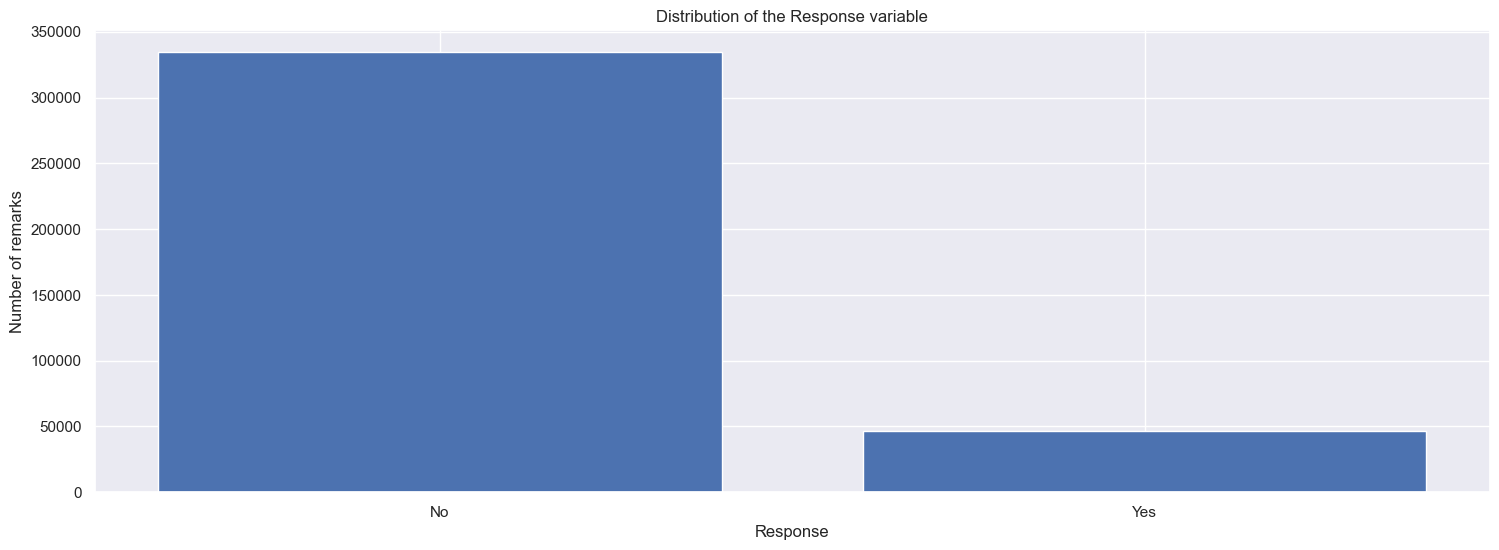

In [244]:
count_response = df3['response'].value_counts()

fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(count_response.index, count_response.values)

ax.set_title('Distribution of the Response variable')
ax.set_xlabel('Response')
ax.set_ylabel('Number of remarks')

plt.show()

### 3.1.2. Numerical Variable

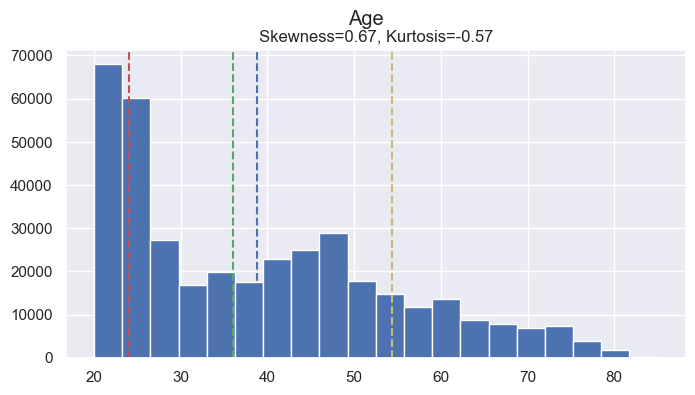

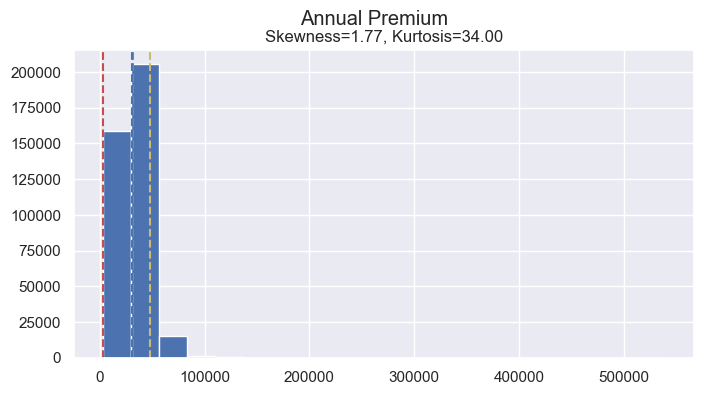

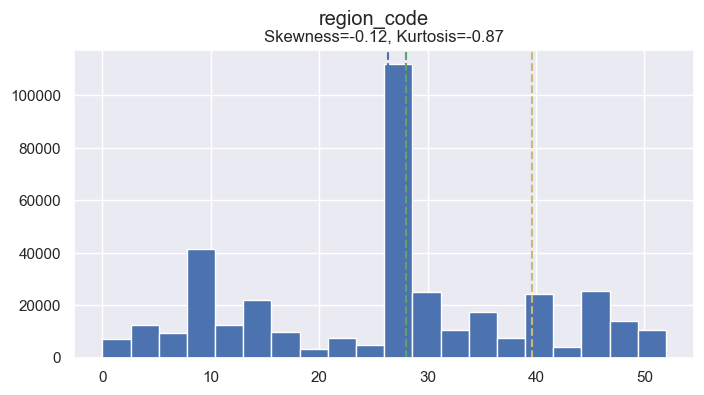

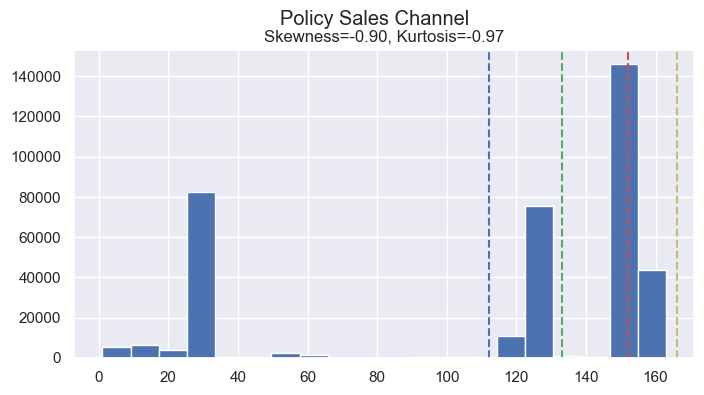

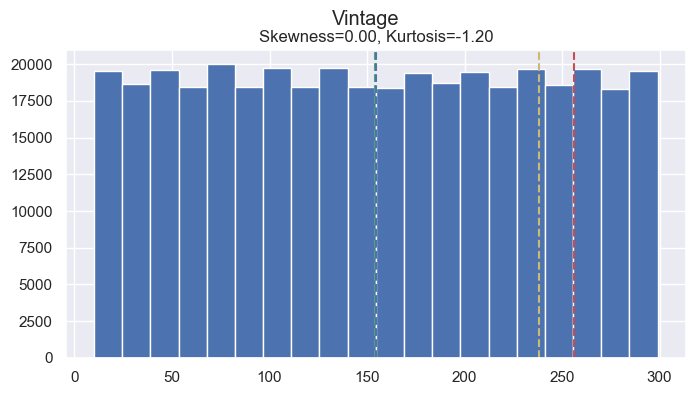

In [250]:
plot_skew_kurtosis(df1['age'], 'Age')

plot_skew_kurtosis(df1['annual_premium'], 'Annual Premium')

plot_skew_kurtosis(df1['region_code'], 'region_code')

plot_skew_kurtosis(df1['policy_sales_channel'], 'Policy Sales Channel')

plot_skew_kurtosis(df1['vintage'], 'Vintage')

### 3.1.3. Categorical Variable

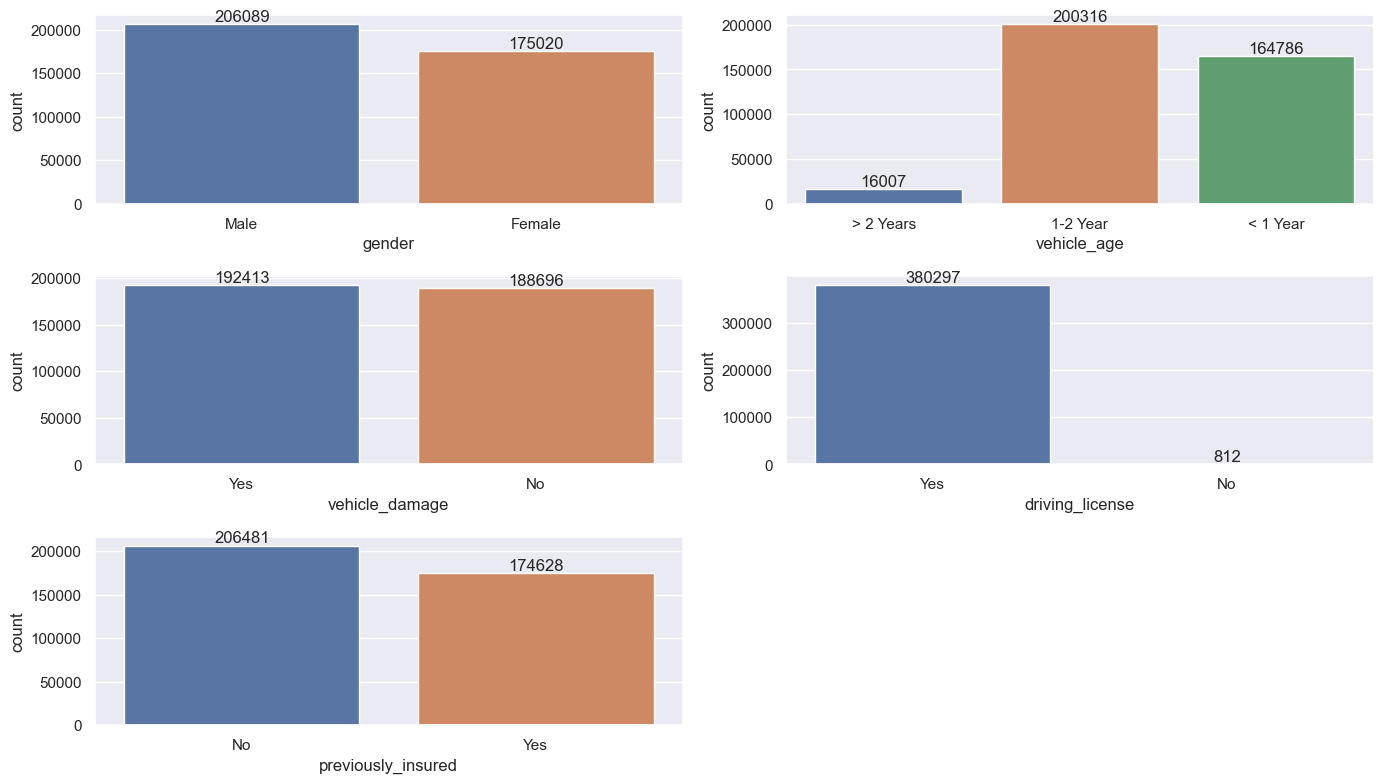

In [264]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))

sns.countplot(x='gender', data=cat_attributes, ax=axs[0, 0])
for p in axs[0, 0].patches:
    axs[0, 0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.0f}', ha='center', va='bottom')

sns.countplot(x='vehicle_age', data=cat_attributes, ax=axs[0, 1])
for p in axs[0, 1].patches:
    axs[0, 1].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.0f}', ha='center', va='bottom')

sns.countplot(x='vehicle_damage', data=cat_attributes, ax=axs[1, 0])
for p in axs[1, 0].patches:
    axs[1, 0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.0f}', ha='center', va='bottom')

sns.countplot(x='driving_license', data=cat_attributes, ax=axs[1, 1])
for p in axs[1, 1].patches:
    axs[1, 1].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.0f}', ha='center', va='bottom')

sns.countplot(x='previously_insured', data=cat_attributes, ax=axs[2, 0])
for p in axs[2, 0].patches:
    axs[2, 0].text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.0f}', ha='center', va='bottom')

plt.delaxes(axs[2, 1])
plt.tight_layout()
plt.show()

## 3.2. Bivariate Analysis

### 3.2.1. Older customers are more likely to be interested in vehicle insurance.

### 3.2.2. Customers who have previously insured their vehicle are less likely to be interested in vehicle insurance as they may already have coverage.

### 3.2.3. Customers who own newer vehicles are more likely to be interested in vehicle insurance as they may have more valuable assets to protect.

### 3.2.4. Customers who have experienced vehicle damage in the past are less likely to be interested in vehicle insurance as they may already have coverage.

### 3.2.5. Customers who have a long association with the insurance company are more likely to be interested in vehicle insurance as they may have a stronger trust relationship with the company.

### 3.2.6. Male customers are more likely to be interested in vehicle insurance as they may be more likely to own and drive vehicles.

### 3.2.7. Customers who have a higher annual premium for their current policy are less likely to be interested in vehicle insurance as they may consider the cost too high.

### 3.2.8. Customers who were contacted through certain policy sales channels, such as over the phone or in person, may be more likely to be interested in vehicle insurance compared to those contacted through other channels, such as over mail or email.

### 3.2.9. Regions with the highest percentage of customers tend to have the widest acceptance area for insurance.

### 3.2.10. Customers who do not have a driver's license tend not to adhere to vehicle insurance.

### 3.2.11. There is a greater risk of accidents occurring in customers who are younger.

### 3.2.12. Customers who own vehicles less than a year old cause more accidents.

## 3.3. Multivariate Analysis

## 4.0. Feature Engineering